In [ ]:
!pip install torchsummary torchgeometry torch pandas numpy==1.23.0 opencv-python wandb pillow imageio albumentations

In [1]:
# !pip install torchinfo
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os
from torchsummary import summary
import torch
import torch.optim as optim

# Data Loader

In [2]:
class ImageData(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path) #995,1280,3
        image = cv2.resize(image, self.resize)#256,256,3
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)#^

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.read_mask(label_path) 
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image=image)['image'] #(-1,3,256,256)
        label = torch.tensor(label, dtype= torch.float32)
        label = label.permute(2, 0, 1)

        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [7]:
image_path = []
# TRAIN_DIR = '/kaggle/input/bkai-polyp/train/train'
TRAIN_DIR = 'train/'
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)
len(image_path)

1000

In [5]:
mask_path = []
# TRAIN_MASK_DIR = '/kaggle/input/bkai-polyp/train_gt/train_gt'
TRAIN_MASK_DIR = 'train_gt/'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
len(mask_path)

1000

In [20]:
batch_size = 8
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.Cutout(p=0.2, max_h_size=35, max_w_size=35, fill_value=255),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.RandomShadow(p=0.1),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dataset_not_aug = ImageData(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (224,224),
                             transform = val_transform)

train_dataset_aug = ImageData(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (224,224),
                             transform = train_transform)
train_dataset = ConcatDataset([train_dataset_not_aug, train_dataset_aug])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))

2000


/Users/quocdetran/miniforge3/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


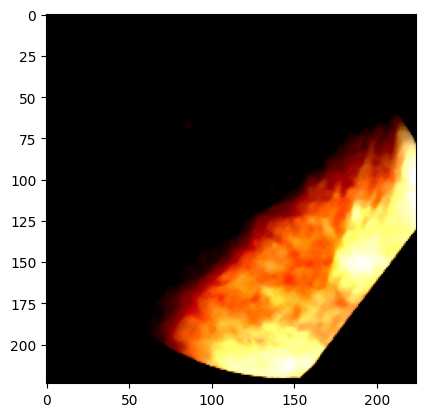

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


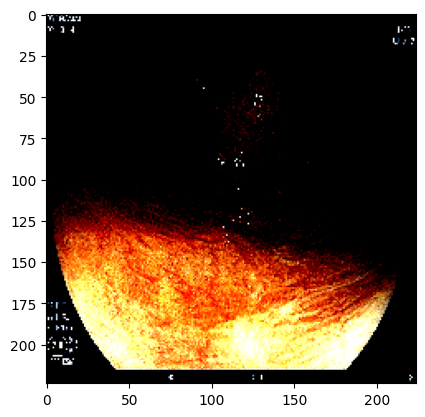

In [27]:
img,_ = train_dataset_aug.__getitem__(1)
img = img.numpy()
img = img.transpose(1,2,0)
plt.imshow(img)
plt.show()
img,_ = train_dataset_not_aug.__getitem__(1)
img = img.numpy()
img = img.transpose(1,2,0)
plt.imshow(img)
plt.show()

In [6]:
for i,(data,label) in enumerate(train_loader):
    print(data.shape)
    print(label.shape)
    break

torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])


# Model Architecture

In [22]:
import torch
import torch.nn as nn
from torchvision.models import resnet152, ResNet152_Weights


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class DecBlock(nn.Module):

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 ):
        super().__init__()

        if up_conv_in_channels is None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels is None:
            up_conv_out_channels = out_channels
        self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        x = self.upsample(up_x) #(-1,1024,-,-)
        x = torch.cat([x, down_x], 1) #(-1,2048,-,-) # channels nhân đôi lên
        x = self.conv_block_1(x)#(-1,1024,-,-)
        x = self.conv_block_2(x)
        return x


class Resnet152Unet(nn.Module):
    # DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = resnet152(weights=ResNet152_Weights.DEFAULT)
        blocks = list(resnet.children())
        enc_blocks = []
        self.input_block= nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.input_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        for enc in list(blocks):
            if isinstance(enc, nn.Sequential):
                enc_blocks.append(enc)
        self.enc_blocks = nn.ModuleList(enc_blocks)
        
        self.bottleneck = BottleNeck(2048, 2048)

        dec_blocks = [
            DecBlock(2048, 1024),
            DecBlock(1024, 512),
            DecBlock(512, 256),
            DecBlock(in_channels=128 + 64, out_channels=128, up_conv_in_channels=256, up_conv_out_channels=128),
            DecBlock(in_channels=64 + 3, out_channels=64, up_conv_in_channels=128, up_conv_out_channels=64)
        ]

        self.dec_blocks = nn.ModuleList(dec_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x):
        pre_skip = dict() # to save skip-connection

        pre_skip["layer0"] = x
        x = self.input_block(x) # (-1,64,112,112)
        pre_skip["layer1"] = x
        x = self.input_pool(x) #-1,64,56,56

        for i, block in enumerate(self.enc_blocks, 2):
            x = block(x)
            if i == 5 :
                continue
            pre_skip[f"layer{i}"] = x # save the skip-connection

        x = self.bottleneck(x) #(-1,2048,224,224)

        for i, block in enumerate(self.dec_blocks, 1):

            key = f"layer{5 - i}"
            x = block(x, pre_skip[key]) # decode with x and saved skip-connection

        x = self.out(x)
        del pre_skip
        return x

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def mask2rgb(mask):
    color_dict = {0: torch.tensor([0, 0, 0]),
                  1: torch.tensor([1, 0, 0]),
                  2: torch.tensor([0, 1, 0])}
    output = torch.zeros((mask.shape[0], mask.shape[1], mask.shape[2], 3)).long()
    for i in range(mask.shape[0]):
        for k in color_dict.keys():
            output[i][mask[i].long() == k] = color_dict[k]
    return output.to(mask.device)


@torch.no_grad()
def dice_score(
    inputs: torch.Tensor,
    targets: torch.Tensor
) -> torch.Tensor:
    # compute softmax over the classes axis
    input_one_hot = mask2rgb(inputs.argmax(dim=1))

    # create the labels one hot tensor
    target_one_hot = mask2rgb(targets)

    # compute the actual dice score
    dims = (2, 3)
    intersection = torch.sum(input_one_hot * target_one_hot, dims)
    cardinality = torch.sum(input_one_hot + target_one_hot, dims)

    dice_score = (2. * intersection + 1e-6) / (cardinality + 1e-6)
    return dice_score.mean()


class DiceLoss(nn.Module):
    def __init__(self, weights=torch.Tensor([[0.4, 0.55, 0.05]])) -> None:
        super(DiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(
            self,
            inputs: torch.Tensor,
            targets: torch.Tensor) -> torch.Tensor:
        # compute softmax over the classes axis
        input_soft = F.softmax(inputs, dim=1)

        # create the labels one hot tensor
        target_one_hot = mask2rgb(targets)

        # compute the actual dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)

        dice_score = torch.sum(
            dice_score * self.weights.to(dice_score.device),
            dim=1
        )
        return torch.mean(1. - dice_score)



In [24]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
torch.cuda.empty_cache()
model = Resnet152Unet(n_classes=3)
model.to(device)

Resnet152Unet(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (input_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_blocks): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (do

In [29]:
import torchsummary
torchsummary.summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
import wandb

In [14]:
!wandb login --relogin cb5c67c48112693f46651a427df0d125433e1027

In [15]:
wandb.init(
    project = 'Segmentation-UNET',
)

In [ ]:
num_epochs = 100
trainsize = 224

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
train_loss_array = []
best_loss = 999
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_acc = 0
    # i = 0
    for images, labels in train_loader:
        # i+=1
        # print(i)
        images = images.to(device) #(-1,3,224,224)
        labels = labels.to(device) #(-1,1,224,2224)
        # Forward pass
        labels = labels.squeeze(dim=1).long()#(-1,224,24)

        outputs = model(images) #(-1,3,224,224)

        loss = criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        print("loss : ",loss)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()  
        total_acc+= acc

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = total_acc / len(train_loader)
    train_loss_array.append(epoch_loss)
    wandb.log({'Loss': epoch_loss , 'Acc: ':acc})
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': epoch_loss
        }
        save_path = '/kaggle/working/saved_model_submission.pth'
        torch.save(checkpoint, save_path)
        print('Save model')
wandb.finish()

In [ ]:
checkpoint = torch.load('/kaggle/working/saved_model_submission.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
optimizer.load_state_dict(checkpoint['optimizer'])

model.to(device)
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
loss_value = checkpoint['loss']

print(f"The loss from the checkpoint is: {loss_value:.10f}")

In [2]:
!mkdir test_pred
!mkdir test_overlappred

In [ ]:
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb_true = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    overlap = 0.7*ori_img+0.3*mask_rgb_true
    overlap = overlap.astype('uint8')
    overlap = cv2.cvtColor(overlap, cv2.COLOR_RGB2BGR)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("test_pred/{}".format(i), mask_rgb)
    cv2.imwrite("test_overlappred/{}".format(i), overlap)
    print("processed ", img_path)
     

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = 'test_predict/' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)